In [ ]:
%pip install pdfminer.six

In [1]:
import os

data_folder = "../../../Data/pdf"
file_path = os.path.join(data_folder, "S100S37P_2.pdf")
encoding = "shift-jis"

# Handle Each Page of PDF

In [8]:
from pdfminer.high_level import extract_pages

pages = extract_pages(file_path)

In [9]:
# This sample has a matrinc in page 2

target_page = 2

for i, page in enumerate(pages):
    if (i+1) == target_page:
        break

The PDF <_io.BufferedReader name='./Data/texts/S100S37P_2.pdf'> contains a metadata field indicating that it should not allow text extraction. Ignoring this field and proceeding. Use the check_extractable if you want to raise an error in this case


In [10]:
for element in page:
    print(element)

<LTTextBoxHorizontal(0) 518.396,829.962,579.276,837.962 'EDINET提出書類\n'>
<LTTextBoxHorizontal(1) 485.060,817.962,579.276,825.962 'デンヨー株式会社(E01758)\n'>
<LTTextBoxHorizontal(2) 531.276,805.962,579.276,813.962 '四半期報告書\n'>
<LTTextBoxHorizontal(3) 868.801,865.962,885.025,873.962 ' 2/20\n'>
<LTTextBoxHorizontal(4) 43.228,790.891,151.228,802.891 '第一部【企業情報】\n'>
<LTTextBoxHorizontal(5) 43.228,772.891,151.228,784.891 '第１【企業の概況】\n'>
<LTTextBoxHorizontal(6) 52.228,756.766,199.228,767.266 '１【主要な経営指標等の推移】\n'>
<LTTextBoxHorizontal(7) 141.978,729.766,159.978,738.766 '回次\n'>
<LTTextBoxHorizontal(8) 132.978,689.892,168.978,698.892 '会計期間\n'>
<LTTextBoxHorizontal(9) 272.228,719.766,335.228,748.766 '第75期\n第２四半期連結\n累計期間\n'>
<LTTextBoxHorizontal(10) 362.228,719.766,425.228,748.766 '第76期\n第２四半期連結\n累計期間\n'>
<LTTextBoxHorizontal(11) 470.478,729.766,497.478,738.766 '第75期\n'>
<LTTextBoxHorizontal(12) 267.728,684.892,339.728,703.892 '自2022年４月１日\n至2022年９月30日\n'>
<LTTextBoxHorizontal(13) 357.728,684.892,429.728,703.8

### Split line elements of a matrix

In [11]:
from pdfminer.layout import LTLine

lines = []

for item in page:
    if isinstance(item, LTLine):
        lines.append(item)

In [12]:
# This is not required. I assumed node have 4 nodes at the most, but sometimes it is invalid. Tree structure is not os good for this case...
import uuid

class Node:

    def __init__(self, line) -> None:
        self.line = line
        self.parent = None
        self.edge_of_parent = None
        self.children = []
        self.id = uuid.uuid4()

    def assign_parent(self, edge ,node):
        self.parent = node
        self.edge_of_parent = edge

    def add_child(self, node):
        self.children.append(node)

    def merge_child(self, nodes:list):
        self.children.extend(nodes)

    @property
    def bbox(self):
        return self.line.bbox

    def __eq__(self, __value: object):
        if self.id == __value.id:
            return True
        else:
            return False

In [13]:
nodes = [Node(lines[0])]
remaining_nodes = [Node(line) for line in lines]

In [14]:
def is_near_point(p1, p2, mergin=1.0):
    if abs(p1 - p2) <= mergin:
        return True
    else:
        return False

In [15]:
def is_adj(base_node, target_node):
    x_l, y_l, x_r, y_t = base_node.bbox
    xt_l, yt_l, xt_r, yt_t = target_node.bbox
    height = abs(yt_t - yt_l)
    width = abs(xt_r - xt_l)
    # indicates (edge_type, bbox). If target_node is connected to base_node, bbox is returned.
    default_response = (-1, None)
    # edge types: 0-> left, 1-> right, 2-> top, 3-> buttom
    is_horizontal_line = abs(x_r - x_l) > 0
    is_vertical_line = abs(y_t - y_l) > 0

    if height > 0 and width > 0:
        print(f"unexpected target bbox. It is not a line: {target_node.bbox}")
        return default_response
    if is_vertical_line is True and is_horizontal_line is True:
        print(f"unexpected base bbox. It is not a line: {target_node.bbox}")
        return default_response
    if height > 0:
        # we can check eigher left or right since width is zero
        # TODO: check if boarder width is related to coordinates
        if is_horizontal_line:
            if is_near_point(y_t, yt_t):
                if is_near_point(x_l, xt_l):
                    return (0, target_node.bbox)
                elif is_near_point(x_r, xt_r):
                    return (1, target_node.bbox)
                elif (x_l < xt_l) and (x_r > xt_l):
                    return (-1, target_node.bbox)
                else:
                    # if there are multiple table or merged cell, this case happens
                    return default_response
            else:
                return default_response
        else:
            if is_near_point(x_l, xt_l):
                if is_near_point(y_t, yt_l):
                    return (2, target_node.bbox)
                elif is_near_point(y_l, yt_t):
                    return (3, target_node.bbox)
                elif (y_l < yt_l) and (y_t > yt_t):
                    return (-1, target_node.bbox)
                else:
                    return default_response
            else:
                return default_response
    elif width > 0:
        if is_vertical_line:
            if is_near_point(x_l, xt_l):
                if is_near_point(y_t, yt_t):
                    return (2, target_node.bbox)
                elif is_near_point(y_l, yt_l):
                    return (3, target_node.bbox)
                elif (y_l < yt_l) and (y_t > yt_t):
                    return (-1, target_node.bbox)
                else:
                    return default_response
            else:
                return default_response
        else:
            if is_near_point(y_t, yt_t):
                if is_near_point(x_l, xt_r):
                    return (0, target_node.bbox)
                elif is_near_point(x_r, xt_l):
                    return (1, target_node.bbox)
                elif (x_l < xt_l) and (x_r > xt_l):
                    return (-1, target_node.bbox)
                else:
                    return default_response
            else:
                return default_response
    else:
        print(f"target line seems to be a point, not a line: {target_node.bbox}")
        return default_response

In [16]:
is_adj(nodes[0], remaining_nodes[0])

(-1, None)

In [17]:
target_line = lines[0]
adjs = []
others = []

for line in lines[1:]:
    edge_type, coord = is_adj(target_line, line)
    if coord is None:
        others.append(line)
    else:
        adjs.append((edge_type, line))

In [18]:
lines[0].bbox

(43.22835, 714.01476, 43.22835, 754.51476)

In [19]:
adjs

[(3, <LTLine 43.228,674.017,43.228,714.765>),
 (2, <LTLine 42.853,754.140,204.728,754.140>),
 (3, <LTLine 42.853,714.390,204.728,714.390>)]

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors

[]

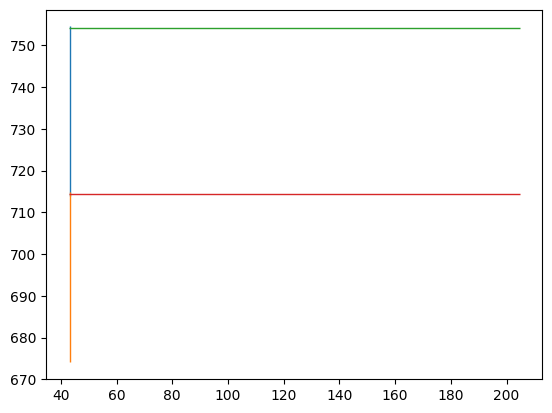

In [23]:
fig, ax = plt.subplots()
colors = list(mcolors.TABLEAU_COLORS.values())
x_min, y_min, x_max, y_max = target_line.bbox
rectangle = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor=colors[0], facecolor='none')
ax.add_patch(rectangle)

for index, line_info in enumerate(adjs):
    color_index = (index + 1) % len(colors)
    _, line = line_info
    x_min, y_min, x_max, y_max = line.bbox
    rectangle = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor=colors[color_index], facecolor='none')
    ax.add_patch(rectangle)
plt.plot()

[]

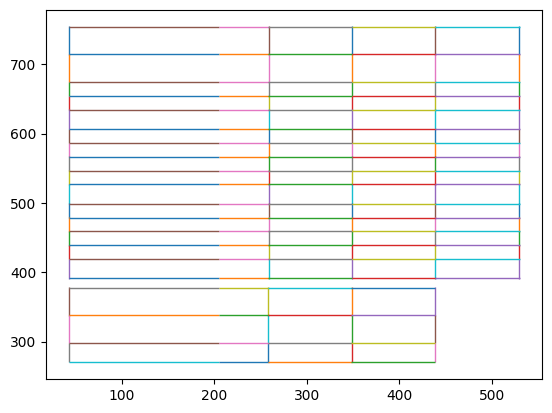

In [24]:
fig, ax = plt.subplots()
colors = list(mcolors.TABLEAU_COLORS.values())

for index, line in enumerate(lines):
    color_index = index % len(colors)
    x_min, y_min, x_max, y_max = line.bbox
    rectangle = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor=colors[color_index], facecolor='none')
    ax.add_patch(rectangle)
plt.plot()

In [25]:
def separate_adjs(target_node, remaining_nodes):
    adjs = []
    others = []
    for item in remaining_nodes:
        edge_type, coord = is_adj(target_node, item)
        if coord is None:
            others.append(Node(item))
        else:
            adjs.append(Node(item))
    return adjs, others

In [29]:
initial_node = Node(lines[0])
remaining_nodes = [Node(item) for item in lines[1:]]
table_nodes = [initial_node]
adjs = [initial_node]

In [30]:
while len(remaining_nodes) > 0:
    pre_length = len(remaining_nodes)
    if len(adjs) > 0:
        new_adjs = []
        for adj in adjs:
            children, remaining_nodes = separate_adjs(adj, remaining_nodes)
            # print(len(children), len(remaining_nodes))
            adj.merge_child(children)
            new_adjs.extend(children)
            table_nodes.append(adj)
        adjs = new_adjs
    else:
        print("no adjs")
        break
    if pre_length == len(remaining_nodes):
        print("Stopped since remaining nodes was not changed")
        break

Stopped since remaining nodes was not changed


In [31]:
import pandas as pd

coords = []

for node in table_nodes:
    coords.append(node.bbox)

coords_df = pd.DataFrame(coords, columns=["x_min", "y_min", "x_max", "y_max"])
coords_df

,x_min,y_min,x_max,y_max
0,43.22835,714.01476,43.22835,754.51476
1,43.22835,714.01476,43.22835,754.51476
2,43.22835,674.01726,43.22835,714.76476
3,42.85335,754.13976,204.72834,754.13976
4,42.85335,714.38976,204.72834,714.38976
...,...,...,...,...
151,438.72835,390.74226,438.72835,419.24226
152,438.35335,418.86726,529.60335,418.86726
153,529.22835,418.49226,529.22835,439.24476
154,438.35335,391.11726,529.60335,391.11726


In [32]:
table_bb = (coords_df.x_min.min(), coords_df.y_min.min(), coords_df.x_max.max(), coords_df.y_max.max())
table_bb

(42.85335, 390.74226, 529.60335, 754.51476)

[]

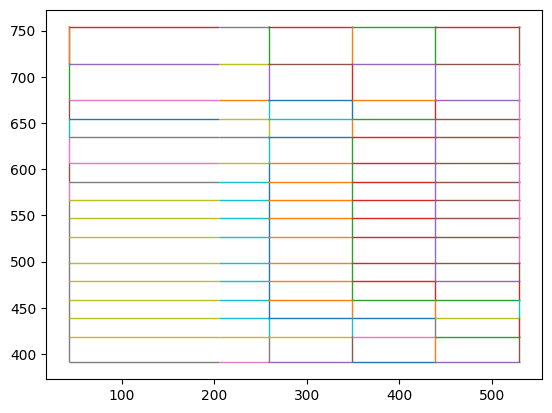

In [33]:
fig, ax = plt.subplots()

for index, node in enumerate(table_nodes):
    color_index = index % len(colors)
    x_min, y_min, x_max, y_max = node.bbox
    rectangle = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor=colors[color_index], facecolor='none')
    ax.add_patch(rectangle)
plt.plot()

### Split txt elements of the matrix

In [34]:
from pdfminer.layout import LTTextContainer

In [35]:
txt_elements = []

for item in page:
    if isinstance(item, LTTextContainer):
        txt_elements.append(item)

In [36]:
def is_in_bb(target_out_bb, target_in_bb):
    x_min, y_min, x_max, y_max = target_out_bb
    xt_min, yt_min, xt_max, yt_max = target_in_bb

    if (x_min <= xt_min) and (y_min <= yt_min) and (x_max >= xt_max) and (y_max >= yt_max):
        return True
    else:
        return False

In [37]:
table_txt_elements = []

for item in txt_elements:
    if is_in_bb(table_bb, item.bbox):
        table_txt_elements.append(item)

In [38]:
table_txt_elements

[<LTTextBoxHorizontal(7) 141.978,729.766,159.978,738.766 '回次\n'>,
 <LTTextBoxHorizontal(8) 132.978,689.892,168.978,698.892 '会計期間\n'>,
 <LTTextBoxHorizontal(9) 272.228,719.766,335.228,748.766 '第75期\n第２四半期連結\n累計期間\n'>,
 <LTTextBoxHorizontal(10) 362.228,719.766,425.228,748.766 '第76期\n第２四半期連結\n累計期間\n'>,
 <LTTextBoxHorizontal(11) 470.478,729.766,497.478,738.766 '第75期\n'>,
 <LTTextBoxHorizontal(12) 267.728,684.892,339.728,703.892 '自2022年４月１日\n至2022年９月30日\n'>,
 <LTTextBoxHorizontal(13) 357.728,684.892,429.728,703.892 '自2023年４月１日\n至2023年９月30日\n'>,
 <LTTextBoxHorizontal(14) 447.978,684.892,519.978,703.892 '自2022年４月１日\n至2023年３月31日\n'>,
 <LTTextBoxHorizontal(15) 48.103,659.892,75.103,668.892 '売上高\n'>,
 <LTTextBoxHorizontal(16) 48.103,639.890,84.103,648.890 '経常利益\n'>,
 <LTTextBoxHorizontal(17) 48.103,622.764,201.103,631.764 '親会社株主に帰属する四半期（当期）\n'>,
 <LTTextBoxHorizontal(18) 48.103,609.264,75.103,618.264 '純利益\n'>,
 <LTTextBoxHorizontal(19) 209.041,659.892,254.041,668.892 '（百万円）\n'>,
 <LTTextBoxHoriz

### Specify bbox of each cell

In [39]:
# Create a table it represents cell info; cells[i, j] = bbox of i,j cell
mergin = 0.5

horizontal_lines = coords_df[coords_df.x_max - coords_df.x_min > mergin]
vertical_lines = coords_df[coords_df.y_max - coords_df.y_min > mergin]

len(horizontal_lines) + len(vertical_lines) == len(coords_df)

True

In [40]:
# coord (0, 0) is buttom left. I sort y value with descending order
left_coord = horizontal_lines[horizontal_lines.x_min == table_bb[0]]
left_coord = left_coord.sort_values(by="y_max", ascending=False)
left_coord

,x_min,y_min,x_max,y_max
3,42.85335,754.13976,204.72834,754.13976
4,42.85335,714.38976,204.72834,714.38976
6,42.85335,674.39226,204.72834,674.39226
10,42.85335,654.38976,204.72834,654.38976
17,42.85335,634.38726,204.72834,634.38726
26,42.85335,606.63726,204.72834,606.63726
37,42.85335,586.63476,204.72834,586.63476
48,42.85335,566.63226,204.72834,566.63226
58,42.85335,546.62976,204.72834,546.62976
68,42.85335,526.62726,204.72834,526.62726


In [41]:
vertical_cell_info = left_coord[["y_min", "y_max"]].reset_index(drop=True)
border_size_y = vertical_cell_info.y_max - vertical_cell_info.y_min
vertical_cell_info

,y_min,y_max
0,754.13976,754.13976
1,714.38976,714.38976
2,674.39226,674.39226
3,654.38976,654.38976
4,634.38726,634.38726
5,606.63726,606.63726
6,586.63476,586.63476
7,566.63226,566.63226
8,546.62976,546.62976
9,526.62726,526.62726


In [42]:
left_coord.y_min.iloc[:-1].values - left_coord.y_max.iloc[1:].values

array([39.75  , 39.9975, 20.0025, 20.0025, 27.75  , 20.0025, 20.0025,
       20.0025, 20.0025, 27.75  , 20.0025, 20.0025, 20.0025, 20.0025,
       27.75  ])

In [43]:
# coord (0, 0) is buttom left. I sort x value with ascending order
top_coord = vertical_lines[vertical_lines.y_max == table_bb[3]]
top_coord = top_coord.sort_values(by="x_min", ascending=True)
top_coord

,x_min,y_min,x_max,y_max
0,43.22835,714.01476,43.22835,754.51476
1,43.22835,714.01476,43.22835,754.51476
12,258.72834,714.01476,258.72834,754.51476
21,348.72835,714.01476,348.72835,754.51476
32,438.72835,714.01476,438.72835,754.51476
45,529.22835,714.01476,529.22835,754.51476


In [45]:
horizontal_cell_info = top_coord[["x_min", "x_max"]]
horizontal_cell_info = horizontal_cell_info.reset_index(drop=True)
border_size_x = horizontal_cell_info.x_max - horizontal_cell_info.x_min
horizontal_cell_info

,x_min,x_max
0,43.22835,43.22835
1,43.22835,43.22835
2,258.72834,258.72834
3,348.72835,348.72835
4,438.72835,438.72835
5,529.22835,529.22835


In [46]:
points = []


for j, h_line in enumerate(vertical_cell_info.values):
    y = h_line[0]
    x_points = []
    for i, v_line in enumerate(horizontal_cell_info.values):
        x = v_line[0]
        x_points.append((x, y))
    points.append(x_points)

In [47]:
points_df = pd.DataFrame(points)

In [48]:
points_df

,0,1,2,3,4,5
0,"(43.22835, 754.13976)","(43.22835, 754.13976)","(258.72834, 754.13976)","(348.72835, 754.13976)","(438.72835, 754.13976)","(529.22835, 754.13976)"
1,"(43.22835, 714.38976)","(43.22835, 714.38976)","(258.72834, 714.38976)","(348.72835, 714.38976)","(438.72835, 714.38976)","(529.22835, 714.38976)"
2,"(43.22835, 674.39226)","(43.22835, 674.39226)","(258.72834, 674.39226)","(348.72835, 674.39226)","(438.72835, 674.39226)","(529.22835, 674.39226)"
3,"(43.22835, 654.38976)","(43.22835, 654.38976)","(258.72834, 654.38976)","(348.72835, 654.38976)","(438.72835, 654.38976)","(529.22835, 654.38976)"
4,"(43.22835, 634.38726)","(43.22835, 634.38726)","(258.72834, 634.38726)","(348.72835, 634.38726)","(438.72835, 634.38726)","(529.22835, 634.38726)"
5,"(43.22835, 606.63726)","(43.22835, 606.63726)","(258.72834, 606.63726)","(348.72835, 606.63726)","(438.72835, 606.63726)","(529.22835, 606.63726)"
6,"(43.22835, 586.63476)","(43.22835, 586.63476)","(258.72834, 586.63476)","(348.72835, 586.63476)","(438.72835, 586.63476)","(529.22835, 586.63476)"
7,"(43.22835, 566.63226)","(43.22835, 566.63226)","(258.72834, 566.63226)","(348.72835, 566.63226)","(438.72835, 566.63226)","(529.22835, 566.63226)"
8,"(43.22835, 546.62976)","(43.22835, 546.62976)","(258.72834, 546.62976)","(348.72835, 546.62976)","(438.72835, 546.62976)","(529.22835, 546.62976)"
9,"(43.22835, 526.62726)","(43.22835, 526.62726)","(258.72834, 526.62726)","(348.72835, 526.62726)","(438.72835, 526.62726)","(529.22835, 526.62726)"


In [49]:
x = 0
y = 2

points_df.iloc[y, x]

(43.22835, 674.39226)

In [106]:
import numpy as np

# method 2 to crerate point matrix
u1 = vertical_lines.x_min.unique()
u2 = horizontal_lines.x_min.unique()

additional_unique = []
for value in u2:
    if True in (abs(u1 - value) < mergin):
        continue
    additional_unique.append(value)

horizontal_points = np.array([*u1, *additional_unique])
horizontal_points.sort()
horizontal_points

array([ 43.22835, 204.72834, 258.72834, 348.72835, 438.72835, 529.22835])

In [107]:
import numpy as np

# method 2 to crerate point matrix
u1 = vertical_lines.y_min.unique()
u2 = horizontal_lines.y_min.unique()

additional_unique = []
for value in u2:
    if True in (abs(u1 - value) < mergin):
        continue
    additional_unique.append(value)

vertical_points = np.array([*u1, *additional_unique])
vertical_points.sort()
vertical_points

array([390.74226, 418.49226, 438.49476, 458.49726, 478.49976, 498.50226,
       526.25226, 546.25476, 566.25726, 586.25976, 606.26226, 634.01226,
       654.01476, 674.01726, 714.01476, 754.13976])

In [139]:
class Point:
    
    __edges_dict = {
        8: "left", 4: "right", 2: "top", 1:"bottom",
        10: "left_top", 9: "left_bottom",
        6: "right_top", 5: "right_bottom"
    }
    
    def __init__(self, x, y) -> None:
        self.x = x
        self.y = y
        # 0:left, 1: right, 2: top, 3: bottom
        self.__lines = [None, None, None, None]
        
    @property
    def left(self):
        return self.__lines[0]
    
    @left.setter
    def left(self, value):
        self.__lines[0] = value
    
    @property
    def right(self):
        return self.__lines[1]
    
    @right.setter
    def right(self, value):
        self.__lines[1] = value
    
    @property
    def top(self):
        return self.__lines[2]
    
    @top.setter
    def top(self, value):
        self.__lines[2] = value
    
    @property
    def bottom(self):
        return self.__lines[3]
    
    @bottom.setter
    def bottom(self, value):
        self.__lines[3] = value
    
    def has_left(self):
        return self.__lines[0] is not None
    
    def has_right(self):
        return self.__lines[1] is not None
    
    def has_top(self):
        return self.__lines[2] is not None
    
    def has_bottom(self):
        return self.__lines[3] is not None
    
    def get_edge_type(self):
        b = 1 if self.__lines[0] is None else 0
        for t in self.__lines[1:]:
            b = b << 1
            if t is None:
                b += 1
        return b

    def edge_type_to_str(self, value):
        if value in self.__edges_dict:
            return self.__edges_dict[value]
        else:
            return None
    
    def __str__(self) -> str:
        return f"({self.x}, {self.y})"

In [51]:
# create point matrix

## This method is depricated since sometimes top, left cells are merged
# points = []
# for j, h_line in enumerate(vertical_cell_info.values):
#     y = h_line[0]
#     x_points = []
#     for i, v_line in enumerate(horizontal_cell_info.values):
#         x = v_line[0]
#         x_points.append(Point(x, y))
#     points.append(x_points)


In [142]:
# create point matrix

points = []
for y in vertical_points:
    x_points = []
    for x in horizontal_points:
        x_points.append(Point(x, y))
    points.append(x_points)

In [111]:
x = 1
y = 1

current_point = points[y][x]
right_point = points[y][x+1]
left_point = points[y][x-1]
top_point = points[y-1][x]
bottom_point = points[y+1][x]

In [112]:
print(current_point, right_point)

(204.72834, 418.49226) (258.72834, 418.49226)


In [118]:
# get_right side
def get_right_line(current_point, right_point):
    candidates = horizontal_lines[(abs(horizontal_lines.y_min - current_point.y) <= mergin)]
    _candidates = candidates[(candidates.x_min - current_point.x < mergin) & (candidates.x_max - right_point.x > -mergin)]
    if len(_candidates) > 0:
        candidates = _candidates
        candidates = candidates.sort_values(by="x_max", ascending=True)
        right_lines = candidates.iloc[0:1]
    else:
        # This case wouldn't happene with method 2
        print(f"unexpectedly found splitted lines on {current_point} for right side")
        candidates = candidates[(candidates.x_min - current_point.x > -mergin) & (candidates.x_max - right_point.x < mergin)]
        candidates = candidates.sort_values(by="x_max", ascending=True)
        right_lines = candidates
    length = len(right_lines)
    if length == 1:
        return right_lines.iloc[0]
    elif length > 1:
        print(f"found multiple lines on {current_point} for right side")
        return right_lines.iloc[0]
    else:
        return None

In [121]:
# get_left side
def get_left_line(current_point, left_point):
    candidates = horizontal_lines[(abs(horizontal_lines.y_min - current_point.y) <= mergin)]
    candidates = candidates[(candidates.x_max - current_point.x > -mergin) & (candidates.x_min - left_point.x < mergin)]
    candidates = candidates.sort_values(by="x_max", ascending=True)
    length = len(candidates)
    if length == 1:
        return candidates.iloc[0]
    elif length > 1:
        print(f"found multiple lines on {current_point} for left side")
        return candidates.iloc[0]
    else:
        return None

In [122]:
# get_bottom_side
def get_bottom_line(current_point, bottom_point):
    candidates = vertical_lines[(abs(vertical_lines.x_min - current_point.x) <= mergin)]
    candidates = candidates[(candidates.y_max - current_point.y > -mergin) & (candidates.y_min - bottom_point.y > -mergin)]
    candidates = candidates.sort_values(by="x_max", ascending=True)
    length = len(candidates)
    if length == 1:
        return candidates.iloc[0]
    elif length > 1:
        print(f"found multiple lines on {current_point} for bottom side")
        return candidates.iloc[0]
    else:
        return None

In [123]:
# get_top_side
def get_top_line(current_point, top_point):
    candidates = vertical_lines[(abs(vertical_lines.x_min - current_point.x) <= mergin)]
    candidates = candidates[(current_point.y - candidates.y_min > -mergin) & (candidates.y_max - top_point.y > -mergin)]
    candidates = candidates.sort_values(by="x_max", ascending=True)
    length = len(candidates)
    if length == 1:
        return candidates.iloc[0]
    elif length > 1:
        print(f"found multiple lines on {current_point} for right side")
        return candidates.iloc[0]
    else:
        return None

In [143]:
y_length = len(points)
for y in range(0, y_length):
    x_length = len(points[y])
    for x in range(0, x_length):
        current_point = points[y][x]
        left_point = points[y][x-1] if x > 0 else None
        right_point = points[y][x+1] if x + 1 < x_length else None
        top_point = points[y+1][x] if y + 1 < y_length else None
        bottom_point = points[y-1][x] if y > 0 else None

        if left_point is not None:
            left_line = get_left_line(current_point, left_point)
            if left_line is not None:
                current_point.left = left_line
        if right_point is not None:
            right_line = get_right_line(current_point, right_point)
            if right_line is not None:
                current_point.right = right_line
        if top_point is not None:
            top_line = get_top_line(current_point, top_point)
            if top_line is not None:
                current_point.top = top_line
        if bottom_point is not None:
            bottom_line = get_bottom_line(current_point, bottom_point)
            if bottom_line is not None:
                current_point.bottom = bottom_line

found multiple lines on (43.22835, 418.49226) for bottom side
found multiple lines on (258.72834, 418.49226) for bottom side
found multiple lines on (348.72835, 418.49226) for bottom side
found multiple lines on (438.72835, 418.49226) for bottom side
found multiple lines on (529.22835, 418.49226) for bottom side
found multiple lines on (43.22835, 438.49476) for bottom side
found multiple lines on (258.72834, 438.49476) for bottom side
found multiple lines on (348.72835, 438.49476) for bottom side
found multiple lines on (438.72835, 438.49476) for bottom side
found multiple lines on (529.22835, 438.49476) for bottom side
found multiple lines on (43.22835, 458.49726) for bottom side
found multiple lines on (258.72834, 458.49726) for bottom side
found multiple lines on (348.72835, 458.49726) for bottom side
found multiple lines on (438.72835, 458.49726) for bottom side
found multiple lines on (529.22835, 458.49726) for bottom side
found multiple lines on (43.22835, 478.49976000000004) for

[]

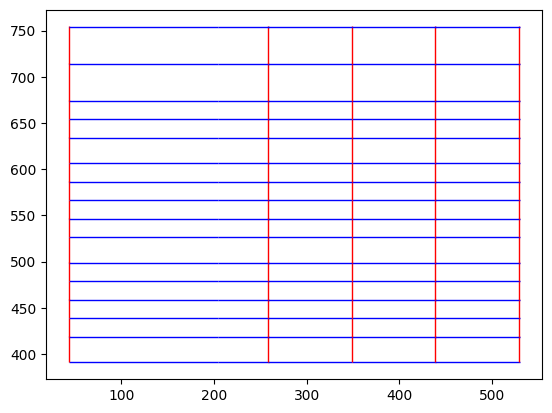

In [131]:
fig, ax = plt.subplots()

for y in range(0, y_length):
    x_length = len(points[y])
    for x in range(0, x_length):
        point = points[y][x]
        if point.right is not None:
            right_line = patches.Rectangle((point.x, point.y), point.right.x_max - point.x, 0, linewidth=1, edgecolor="b", facecolor='none')
            ax.add_patch(right_line)
        if point.top is not None:
            top_line = patches.Rectangle((point.x, point.y), 0, point.top.y_max - point.y, linewidth=1, edgecolor="red", facecolor='none')
            ax.add_patch(top_line)
plt.plot()

In [189]:
cell_bbox = [[(0, 0, 0, 0) for x in range(0, len(horizontal_points) -1)] for y in range(0, len(vertical_points) -1)]

for y in range(0, y_length-1):
    for x in range(0, x_length-1):
        current_point = points[y][x]
        if cell_bbox[y][x] is None:
            continue

        next_y_point = None
        y_ = y + 1
        while next_y_point is None:
            if y_ < len(points):
                _point = points[y_][x]
                if _point.right is None:
                    cell_bbox[y_][x] = None
                    y_ += 1
                else:
                    next_y_point = _point
            else:
                print(f"next y over the limit on ({x}, {y})")
                break
        
        next_x_point = None
        x_ = x + 1
        while next_x_point is None:
            if x_ < len(points[y]):
                _point = points[y][x_]
                if _point.bottom is None:
                    if x_ < len(points[y]) -1:
                        y_limit = y_ if y_ < len(cell_bbox) else len(cell_bbox)
                        for temp_y in range(y, y_limit):
                            cell_bbox[temp_y][x_] = None
                    x_ += 1
                else:
                    next_x_point = _point
            else:
                print(f"next x over the limit on ({x}, {y})")
                break
        
        if next_x_point is None or next_y_point is None:
            print(f"Something went worng on ({x}, {y}). {x_}: {next_x_point}, {y_}: {next_y_point}.")
            cell_bbox[y][x] = None
            continue

        # x_min, y_min, x_max, y_max. left bottom is (0, 0)
        cell_bbox[y][x] = (current_point.x, current_point.y, next_x_point.x, next_y_point.y)

next x over the limit on (0, 0)
Something went worng on (0, 0). 6: None, 1: (43.22835, 418.49226).


### Split text by a bbox of a cell

In [173]:
table_txt_elements[0].get_text()

'回次\n'

In [193]:
table_txt_elements[0].bbox

(141.97835, 729.76603, 159.97835, 738.76603)

In [192]:
cell_bbox[-1][0]

(43.22835, 714.01476, 258.72834, 754.13976)

In [291]:
cell_texts = [[None for x in range(0, len(horizontal_points) -1)] for y in range(0, len(vertical_points) -1)]

for y in range(len(cell_bbox)):
    for x in range(len(cell_bbox[y])):
        bbox = cell_bbox[y][x]
        if bbox is not None:
            texts = []
            
            for text_ele in table_txt_elements:
                if is_in_bb(bbox, text_ele.bbox) is True:
                    texts.append(text_ele.get_text())
            cell_texts[y][x] = "".join(texts).encode(encoding).decode(encoding).encode("utf-8").decode("utf-8")

In [292]:
table = pd.DataFrame(reversed(cell_texts))
table = table.dropna(how="all")
table = table.T.dropna(how="all").T
table

,0,2,3,4
0,回次\n,第75期\n第２四半期連結\n累計期間\n,第76期\n第２四半期連結\n累計期間\n,第75期\n
1,会計期間\n,自2022年４月１日\n至2022年９月30日\n,自2023年４月１日\n至2023年９月30日\n,自2022年４月１日\n至2023年３月31日\n
2,売上高\n（百万円）\n,"28,271\n","34,201\n","64,311\n"
3,経常利益\n（百万円）\n,"1,157\n","2,305\n","5,180\n"
4,親会社株主に帰属する四半期（当期）\n純利益\n（百万円）\n,800\n,"1,598\n","3,633\n"
5,四半期包括利益又は包括利益\n（百万円）\n,"3,238\n","4,118\n","6,055\n"
6,純資産額\n（百万円）\n,"66,470\n","72,176\n","68,658\n"
7,総資産額\n（百万円）\n,"85,049\n","94,916\n","89,744\n"
8,１株当たり四半期（当期）純利益\n（円）\n,38.64\n,77.46\n,175.64\n
9,潜在株式調整後１株当たり\n四半期（当期）純利益\n（円）\n,−\n,−\n,−\n


In [293]:
table.to_csv("P2-1.csv", encoding="utf-8")

### Create functions for above processes

In [2]:
# To check the logic, restart the kernel and proceed it again
from pdfminer.high_level import extract_pages

pages = extract_pages(file_path)
mergin = 0.5

In [3]:
class Point:
    
    __edges_dict = {
        8: "left", 4: "right", 2: "top", 1:"bottom",
        10: "left_top", 9: "left_bottom",
        6: "right_top", 5: "right_bottom"
    }
    
    def __init__(self, x, y) -> None:
        self.x = x
        self.y = y
        # 0:left, 1: right, 2: top, 3: bottom
        self.__lines = [None, None, None, None]
        
    @property
    def left(self):
        return self.__lines[0]
    
    @left.setter
    def left(self, value):
        self.__lines[0] = value
    
    @property
    def right(self):
        return self.__lines[1]
    
    @right.setter
    def right(self, value):
        self.__lines[1] = value
    
    @property
    def top(self):
        return self.__lines[2]
    
    @top.setter
    def top(self, value):
        self.__lines[2] = value
    
    @property
    def bottom(self):
        return self.__lines[3]
    
    @bottom.setter
    def bottom(self, value):
        self.__lines[3] = value
    
    def has_left(self):
        return self.__lines[0] is not None
    
    def has_right(self):
        return self.__lines[1] is not None
    
    def has_top(self):
        return self.__lines[2] is not None
    
    def has_bottom(self):
        return self.__lines[3] is not None
    
    def get_edge_type(self):
        b = 1 if self.__lines[0] is None else 0
        for t in self.__lines[1:]:
            b = b << 1
            if t is None:
                b += 1
        return b

    def edge_type_to_str(self, value):
        if value in self.__edges_dict:
            return self.__edges_dict[value]
        else:
            return None
    
    def __str__(self) -> str:
        return f"({self.x}, {self.y})"

In [4]:
import numpy as np
import pandas as pd
from pdfminer.layout import LTLine
from pdfminer.layout import LTPage
from pdfminer.layout import LTTextContainer


def is_near_point(p1, p2, mergin=1.0):
    if abs(p1 - p2) <= mergin:
        return True
    else:
        return False
    
def retrieve_lines(page):
    lines = []
    for item in page:
        if isinstance(item, LTLine):
            lines.append(item)
    return lines

def is_adj(base_node, target_node):
    x_l, y_l, x_r, y_t = base_node.bbox
    xt_l, yt_l, xt_r, yt_t = target_node.bbox
    height = abs(yt_t - yt_l)
    width = abs(xt_r - xt_l)
    # indicates (edge_type, bbox). If target_node is connected to base_node, bbox is returned.
    default_response = (-1, None)
    # edge types: 0-> left, 1-> right, 2-> top, 3-> buttom
    is_horizontal_line = abs(x_r - x_l) > 0
    is_vertical_line = abs(y_t - y_l) > 0

    if height > 0 and width > 0:
        print(f"unexpected target bbox. It is not a line: {target_node.bbox}")
        return default_response
    if is_vertical_line is True and is_horizontal_line is True:
        print(f"unexpected base bbox. It is not a line: {target_node.bbox}")
        return default_response
    if height > 0:
        # we can check eigher left or right since width is zero
        # TODO: check if boarder width is related to coordinates
        if is_horizontal_line:
            if is_near_point(y_t, yt_t):
                if is_near_point(x_l, xt_l):
                    return (0, target_node.bbox)
                elif is_near_point(x_r, xt_r):
                    return (1, target_node.bbox)
                elif (x_l < xt_l) and (x_r > xt_l):
                    return (-1, target_node.bbox)
                else:
                    # if there are multiple table or merged cell, this case happens
                    return default_response
            else:
                return default_response
        else:
            if is_near_point(x_l, xt_l):
                if is_near_point(y_t, yt_l):
                    return (2, target_node.bbox)
                elif is_near_point(y_l, yt_t):
                    return (3, target_node.bbox)
                elif (y_l < yt_l) and (y_t > yt_t):
                    return (-1, target_node.bbox)
                else:
                    return default_response
            else:
                return default_response
    elif width > 0:
        if is_vertical_line:
            if is_near_point(x_l, xt_l):
                if is_near_point(y_t, yt_t):
                    return (2, target_node.bbox)
                elif is_near_point(y_l, yt_l):
                    return (3, target_node.bbox)
                elif (y_l < yt_l) and (y_t > yt_t):
                    return (-1, target_node.bbox)
                else:
                    return default_response
            else:
                return default_response
        else:
            if is_near_point(y_t, yt_t):
                if is_near_point(x_l, xt_r):
                    return (0, target_node.bbox)
                elif is_near_point(x_r, xt_l):
                    return (1, target_node.bbox)
                elif (x_l < xt_l) and (x_r > xt_l):
                    return (-1, target_node.bbox)
                else:
                    return default_response
            else:
                return default_response
    else:
        print(f"target line seems to be a point, not a line: {target_node.bbox}")
        return default_response

def separate_adjs(target_node, remaining_nodes):
    adjs = []
    others = []
    for item in remaining_nodes:
        edge_type, coord = is_adj(target_node, item)
        if coord is None:
            others.append(item)
        else:
            adjs.append(item)
    return adjs, others

def retrieve_a_table_lines(target_lines: list):
    initial_node = target_lines[0]
    table_nodes = [initial_node]
    adjs = [initial_node]
    remaining_nodes = target_lines[1:].copy()
    while len(remaining_nodes) > 0:
        pre_length = len(remaining_nodes)
        if len(adjs) > 0:
            new_adjs = []
            for adj in adjs:
                children, remaining_nodes = separate_adjs(adj, remaining_nodes)
                # print(len(children), len(remaining_nodes))
                # adj.merge_child(children)
                new_adjs.extend(children)
                table_nodes.append(adj)
            adjs = new_adjs
        else:
            # print("no adjs")
            break
        if pre_length == len(remaining_nodes):
            # print("Stopped since remaining nodes was not changed")
            break
    if len(table_nodes) > 3:
        return table_nodes, remaining_nodes
    else:
        return None, [*table_nodes, *remaining_nodes]

def to_bbox_df(table_lines):
    coords = []
    for node in table_lines:
        coords.append(node.bbox)

    coords_df = pd.DataFrame(coords, columns=["x_min", "y_min", "x_max", "y_max"])
    table_bb = (coords_df.x_min.min(), coords_df.y_min.min(), coords_df.x_max.max(), coords_df.y_max.max())
    return coords_df, table_bb

def retrieve_text_elements(page):
    txt_elements = []

    for item in page:
        if isinstance(item, LTTextContainer):
            txt_elements.append(item)
    return txt_elements

def is_in_bb(target_out_bb, target_in_bb):
    x_min, y_min, x_max, y_max = target_out_bb
    xt_min, yt_min, xt_max, yt_max = target_in_bb

    if (x_min <= xt_min) and (y_min <= yt_min) and (x_max >= xt_max) and (y_max >= yt_max):
        return True
    else:
        return False
    
def get_txt_for_table(table_bb, txt_elements=None, page=None):
    if txt_elements is None and page is None:
        raise ValueError("either txt_elements or page is required.")
    table_txt_elements = []
    if txt_elements is not None:
        for item in txt_elements:
            if is_in_bb(table_bb, item.bbox):
                table_txt_elements.append(item)
    elif page is not None:
        for item in page:
            if isinstance(item, LTTextContainer):
                if is_in_bb(table_bb, item.bbox):
                    table_txt_elements.append(item)
    return table_txt_elements

def split_hv_lines(data):
    if isinstance(data, list):
        coord_df, _ = to_bbox_df(data)
    elif isinstance(data, pd.DataFrame):
        coord_df = data
    horizontal_lines = data[data.x_max - data.x_min > mergin]
    vertical_lines = data[data.y_max - data.y_min > mergin]
    return horizontal_lines, vertical_lines

def create_unique_points(horizontal_lines, vertical_lines):
    u1 = vertical_lines.x_min.unique()
    u2 = horizontal_lines.x_min.unique()

    additional_unique = []
    for value in u2:
        if True in (abs(u1 - value) < mergin):
            continue
        additional_unique.append(value)

    horizontal_points = np.array([*u1, *additional_unique])
    horizontal_points.sort()

    u1 = vertical_lines.y_min.unique()
    u2 = horizontal_lines.y_min.unique()

    additional_unique = []
    for value in u2:
        if True in (abs(u1 - value) < mergin):
            continue
        additional_unique.append(value)

    vertical_points = np.array([*u1, *additional_unique])
    vertical_points.sort()

    return horizontal_points, vertical_points

def create_matrix(horizontal_points, vertical_points):
    points = []
    for y in vertical_points:
        x_points = []
        for x in horizontal_points:
            x_points.append(Point(x, y))
        points.append(x_points)
    return points


# get_right side
def get_right_line(current_point, right_point, horizontal_lines):
    candidates = horizontal_lines[(abs(horizontal_lines.y_min - current_point.y) <= mergin)]
    candidates = candidates[(candidates.x_min - current_point.x < mergin) & (candidates.x_max - right_point.x > -mergin)]
    candidates = candidates.sort_values(by="x_max", ascending=True)
    right_lines = candidates.iloc[0:1]
    length = len(right_lines)
    if length == 1:
        return right_lines.iloc[0]
    elif length > 1:
        # print(f"found multiple lines on {current_point} for right side")
        return right_lines.iloc[0]
    else:
        return None
    
# get_left side
def get_left_line(current_point, left_point, horizontal_lines):
    candidates = horizontal_lines[(abs(horizontal_lines.y_min - current_point.y) <= mergin)]
    candidates = candidates[(candidates.x_max - current_point.x > -mergin) & (candidates.x_min - left_point.x < mergin)]
    candidates = candidates.sort_values(by="x_max", ascending=True)
    length = len(candidates)
    if length == 1:
        return candidates.iloc[0]
    elif length > 1:
        # print(f"found multiple lines on {current_point} for left side")
        return candidates.iloc[0]
    else:
        return None
    
# get_bottom_side
def get_bottom_line(current_point, bottom_point, vertical_lines):
    candidates = vertical_lines[(abs(vertical_lines.x_min - current_point.x) <= mergin)]
    candidates = candidates[(candidates.y_max - current_point.y > -mergin) & (candidates.y_min - bottom_point.y > -mergin)]
    candidates = candidates.sort_values(by="x_max", ascending=True)
    length = len(candidates)
    if length == 1:
        return candidates.iloc[0]
    elif length > 1:
        # print(f"found multiple lines on {current_point} for bottom side")
        return candidates.iloc[0]
    else:
        return None
    
# get_top_side
def get_top_line(current_point, top_point, vertical_lines):
    candidates = vertical_lines[(abs(vertical_lines.x_min - current_point.x) <= mergin)]
    candidates = candidates[(current_point.y - candidates.y_min > -mergin) & (candidates.y_max - top_point.y > -mergin)]
    candidates = candidates.sort_values(by="x_max", ascending=True)
    length = len(candidates)
    if length == 1:
        return candidates.iloc[0]
    elif length > 1:
        # print(f"found multiple lines on {current_point} for right side")
        return candidates.iloc[0]
    else:
        return None
    
def create_unique_points_matrix(horizontal_lines, vertical_lines):
    h_points, v_points = create_unique_points(horizontal_lines, vertical_lines)
    points = create_matrix(h_points, v_points)
    y_length = len(points)
    for y in range(0, y_length):
        x_length = len(points[y])
        for x in range(0, x_length):
            current_point = points[y][x]
            left_point = points[y][x-1] if x > 0 else None
            right_point = points[y][x+1] if x + 1 < x_length else None
            top_point = points[y+1][x] if y + 1 < y_length else None
            bottom_point = points[y-1][x] if y > 0 else None

            if left_point is not None:
                left_line = get_left_line(current_point, left_point, horizontal_lines)
                if left_line is not None:
                    current_point.left = left_line
            if right_point is not None:
                right_line = get_right_line(current_point, right_point, horizontal_lines)
                if right_line is not None:
                    current_point.right = right_line
            if top_point is not None:
                top_line = get_top_line(current_point, top_point, vertical_lines)
                if top_line is not None:
                    current_point.top = top_line
            if bottom_point is not None:
                bottom_line = get_bottom_line(current_point, bottom_point, vertical_lines)
                if bottom_line is not None:
                    current_point.bottom = bottom_line
    return points

def create_cellar_matrix(points):
    y_length = len(points)
    x_length = len(points[0])
    # length - 1 as cell is less than intersection points
    cell_bbox = [[(0, 0, 0, 0) for x in range(0, x_length -1)] for y in range(0, y_length -1)]
    for y in range(0, y_length-1):
        for x in range(0, x_length-1):
            current_point = points[y][x]
            if cell_bbox[y][x] is None:
                continue

            next_y_point = None
            y_ = y + 1
            while next_y_point is None:
                if y_ < len(points):
                    _point = points[y_][x]
                    if _point.right is None:
                        cell_bbox[y_][x] = None
                        y_ += 1
                    else:
                        next_y_point = _point
                else:
                    print(f"next y over the limit on ({x}, {y})")
                    break
            
            next_x_point = None
            x_ = x + 1
            while next_x_point is None:
                if x_ < len(points[y]):
                    _point = points[y][x_]
                    if _point.bottom is None:
                        if x_ < len(points[y]) -1:
                            y_limit = y_ if y_ < len(cell_bbox) else len(cell_bbox)
                            for temp_y in range(y, y_limit):
                                cell_bbox[temp_y][x_] = None
                        x_ += 1
                    else:
                        next_x_point = _point
                else:
                    # print(f"next x over the limit on ({x}, {y})")
                    break
            
            if next_x_point is None or next_y_point is None:
                # print(f"Something went worng on ({x}, {y}). {x_}: {next_x_point}, {y_}: {next_y_point}.")
                cell_bbox[y][x] = None
                continue

            # x_min, y_min, x_max, y_max. left bottom is (0, 0)
            cell_bbox[y][x] = (current_point.x, current_point.y, next_x_point.x, next_y_point.y)
    return cell_bbox

def retrieve_texts_of_cell(cellar_matrix, table_elements, source_encoding="utf-8", to_encoding="utf-8"):
    cell_texts = [[None for x in range(0, len(cellar_matrix[0]))] for y in range(0, len(cellar_matrix))]

    for y in range(len(cellar_matrix)):
        for x in range(len(cellar_matrix[y])):
            bbox = cellar_matrix[y][x]
            if bbox is not None:
                texts = []
                
                for text_ele in table_elements:
                    if is_in_bb(bbox, text_ele.bbox) is True:
                        texts.append(text_ele.get_text())
                cell_texts[y][x] = "".join(texts).encode(source_encoding).decode(source_encoding).encode(to_encoding).decode(to_encoding)
    return cell_texts

def save_to_csv(cell_texts, path, encoding="utf-8"):
    table = pd.DataFrame(reversed(cell_texts))
    table = table.dropna(how="all")
    table = table.T.dropna(how="all").T
    table.to_csv(path, encoding=encoding)

In [5]:
for page_num, page in enumerate(pages):
    texts = retrieve_text_elements(page)
    lines = retrieve_lines(page)
    
    if lines is not None and len(lines) > 3:
        table_lines, remaining = retrieve_a_table_lines(lines)
        pre_length = -1
        if table_lines is not None:
            table_lines_array = [table_lines]
        else:
            table_lines_array = []

        while len(remaining) > 0 and pre_length != len(remaining):
            pre_length = len(remaining)
            table_lines, remaining = retrieve_a_table_lines(remaining)
            if table_lines is not None:
                table_lines_array.append(table_lines)

        print(f"found {len(table_lines_array)} table(s) on {page_num}.")

        for index, table_lines in enumerate(table_lines_array):
            coord_df, table_bbox = to_bbox_df(table_lines)
            table_text_elements = get_txt_for_table(table_bbox, texts)
            h_lines, v_lines = split_hv_lines(coord_df)
            points = create_unique_points_matrix(h_lines, v_lines)
            celler_matrix = create_cellar_matrix(points)
            cell_texts = retrieve_texts_of_cell(celler_matrix, table_text_elements, source_encoding="utf-8")
            save_to_csv(cell_texts, f"./test_table_texts_{page_num}_t-{index}.csv")
        break
    else:
        print(f"no table found on {page_num}")

The PDF <_io.BufferedReader name='../../../Data/pdf\\S100S37P_2.pdf'> contains a metadata field indicating that it should not allow text extraction. Ignoring this field and proceeding. Use the check_extractable if you want to raise an error in this case


no table found on 0
found 2 table(s) on 1.


In [7]:
table_lines_array[1]

[<LTLine 43.228,714.015,43.228,754.515>,
 <LTLine 43.228,714.015,43.228,754.515>,
 <LTLine 43.228,674.017,43.228,714.765>,
 <LTLine 42.853,754.140,204.728,754.140>,
 <LTLine 42.853,714.390,204.728,714.390>,
 <LTLine 43.228,654.015,43.228,674.767>,
 <LTLine 42.853,674.392,204.728,674.392>,
 <LTLine 204.728,754.140,259.103,754.140>,
 <LTLine 204.728,714.390,259.103,714.390>,
 <LTLine 43.228,634.012,43.228,654.765>,
 <LTLine 42.853,654.390,204.728,654.390>,
 <LTLine 204.728,674.392,259.103,674.392>,
 <LTLine 258.728,714.015,258.728,754.515>,
 <LTLine 258.353,754.140,349.103,754.140>,
 <LTLine 258.728,674.017,258.728,714.765>,
 <LTLine 258.353,714.390,349.103,714.390>,
 <LTLine 43.228,606.262,43.228,634.762>,
 <LTLine 42.853,634.387,204.728,634.387>,
 <LTLine 204.728,654.390,259.103,654.390>,
 <LTLine 258.728,654.015,258.728,674.767>,
 <LTLine 258.353,674.392,349.103,674.392>,
 <LTLine 348.728,714.015,348.728,754.515>,
 <LTLine 348.353,754.140,439.103,754.140>,
 <LTLine 348.728,674.017,348